## Initial Modeling Attempt: Small Business Loans with Random Forrest

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

In [2]:
df = pd.read_csv("../Data/Processed/sba_cleaned.csv")

## Preparing the Data

To start, we load in the cleaned data from our initial data wrangling.

In [3]:
## Recall the feature names from our data.
df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'LowDoc',
       'ChgOffDate', 'DisbursementDate', 'DisbursementGross', 'BalanceGross',
       'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')

In [4]:
##It appears that I've accidentally added an extra column called `Unnamed: 0`! Let's remove it.
df = df.drop(df.columns[0], axis = 1)

We choose the features to use in our model. Some features, such as `ChgOffDate` and clearly relate to the eventual fate of the loan, so are not appropriate to use in our model. Similarly, we drop `DisbursementDate`, `DisbursementGross`, `BalanceGross` and `ChgOffPrinGr`. It is not obvious whether CreateJob and RetainedJob refer to projections from the loan application, or later follow-up. We leave them in for now. To simplify the initial model, we drop `ApprovalDate` keep only `ApprovalFY`.

We also remove the `ID`, `City`, `Zip`, `Bank`, `BankState` and `FranchiseCode.` These categorical variables have a large number of values, which would create memory issues with one-hot encoding.

We subset on the remaining columns, and drop rows with missing values.

In [5]:
## Create list of features to use for our model
features = ['State', 'NAICS', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'UrbanRural','LowDoc', 'MIS_Status', 'GrAppv', 'SBA_Appv']

In [6]:
## Subset on relevant columns
df_pred = df[features]

In [7]:
df_pred.isna().sum()

State              13
NAICS          200866
ApprovalFY          0
Term                0
NoEmp               0
NewExist         1160
CreateJob           0
RetainedJob         0
UrbanRural          0
LowDoc           6007
MIS_Status       1974
GrAppv              0
SBA_Appv            0
dtype: int64

In [8]:
df_pred.shape

(898080, 13)

In [9]:
import matplotlib.pyplot as plt
x = df_pred.RetainedJob.value_counts()
x

0       439319
1        88790
2        76851
3        49963
4        39666
         ...  
183          1
1300         1
3200         1
274          1
815          1
Name: RetainedJob, Length: 358, dtype: int64

In [10]:
## Drop rows with missing values
df_pred = df_pred.dropna(axis = 0)

Since csv format does not keep track of data stypes, we must examine those and reset as needed.

In [11]:
## Examine the data types.
df_pred.dtypes

State           object
NAICS          float64
ApprovalFY      object
Term             int64
NoEmp            int64
NewExist       float64
CreateJob        int64
RetainedJob      int64
UrbanRural       int64
LowDoc          object
MIS_Status      object
GrAppv         float64
SBA_Appv       float64
dtype: object

In [12]:
## Columns to be converted to categories
cat_cols = ['State', 'NAICS', 'NewExist', 'UrbanRural', 'LowDoc', 'MIS_Status']
df_pred[cat_cols] = df_pred[cat_cols].apply(lambda x: x.astype('category'))

In [13]:
## Save approval year as an integer
df_pred['ApprovalFY'] = df_pred['ApprovalFY'].apply(lambda x: int(x[:4]))

In [14]:
df_pred.dtypes

State          category
NAICS          category
ApprovalFY        int64
Term              int64
NoEmp             int64
NewExist       category
CreateJob         int64
RetainedJob       int64
UrbanRural     category
LowDoc         category
MIS_Status     category
GrAppv          float64
SBA_Appv        float64
dtype: object

There are are a large number of NAICS codes, which may create memory issues with one-hot encoding. However, the first two digits of the NAICS code keeps track of the overeall type of industry. We simplify by replacing NAICS code with its first two digits.

In [15]:
## First two digits of each industry code
df_pred['Industry'] = df_pred['NAICS'].apply(lambda x: str(x)[:2])

In [16]:
df_pred['Industry'] = df_pred['Industry'].astype('category')

In [17]:
df_pred = df_pred.drop('NAICS', axis = 1)

We use one-hot encoding to encode categorical variables as numeric. 

In [18]:
## One-hot encode categorical features
df_features = pd.get_dummies(df_pred)

In [19]:
## Inspect our new list of features
df_features.columns
len(df_features.columns)

91

In [20]:
## One-hot encoding creates two columns corresponding to MIS Status.
## Drop the MIS_Status_PIF column
df_features = df_features.drop(df_features.columns[-25], axis = 1)

In [21]:
## Array of predictors
X = df_features.drop('MIS_Status_CHGOFF', axis = 1).values
labels = df_features.drop('MIS_Status_CHGOFF', axis = 1).columns

In [22]:
## Column of labels
y = df_features['MIS_Status_CHGOFF'].values

## Training the Model

We train a random forrest model, using 20% of our data as a training set. We scale the features using standard scalar.

Question: should the scalar be applied to columns representing categorical data?

In [23]:
## Split data in to test and train
## Switch to 70% training, 30 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
## Fit a Random Forrest model, making sure to scale the data first
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state = 0)
)

In [25]:
## Fit the model
RF_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

In [26]:
## Make predictions
y_te_pred = RF_pipe.predict(X_test)

In [27]:
## Acurracy score on the test set is nearly 93%. Not bad for a first try!
accuracy_score(y_test, y_te_pred)

0.9295228289478454

In [28]:
from sklearn.metrics import f1_score
f1_score(y_test, y_te_pred)

0.8158602659796157

In [29]:
RF_pipe.named_steps

{'standardscaler': StandardScaler(),
 'randomforestclassifier': RandomForestClassifier(random_state=0)}

### Feature Importances

What features are contributing most to the model? What does this tell us?

In [30]:
importances = RF_pipe['randomforestclassifier'].feature_importances_

## Create a data frame listing feature names and importances
features_ranked = pd.DataFrame(zip(labels, importances), columns = ['feature name', 'importance'])

In [34]:
## Print a table showing the tope 20 features
features_ranked = features_ranked.sort_values('importance', ascending = False)
features_ranked.head(20)

,feature name,importance
1,Term,0.449524
0,ApprovalFY,0.096702
6,SBA_Appv,0.077033
5,GrAppv,0.067839
2,NoEmp,0.042979
4,RetainedJob,0.037022
3,CreateJob,0.024315
60,UrbanRural_0,0.009092
61,UrbanRural_1,0.007856
11,State_CA,0.007552


Text(0, 0.5, 'Name')

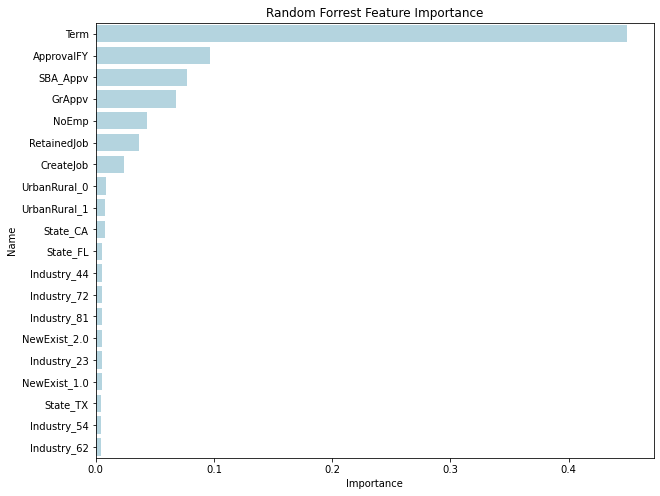

In [35]:
import seaborn as sns
plt.figure(figsize=(10,8))
top_features = features_ranked[:20]
sns.barplot(x=top_features['importance'], y=top_features['feature name'], color = 'lightblue')
#Add chart labels
plt.title('Random Forrest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Name')

We note that fiscal year is one of the most important features! This is concerning--how will a model that depends on year-by-year trends be able to predict future data? We need to account for variation between years somehow.

## Correlations among top features

Let's see which--if any--of the top features correlate with each other. (Question: Should I remove redundant "dummy variables"?

In [37]:
all_cols = list(top_features['feature name'])
all_cols.append('MIS_Status_CHGOFF')
top_cols = df_features[all_cols]

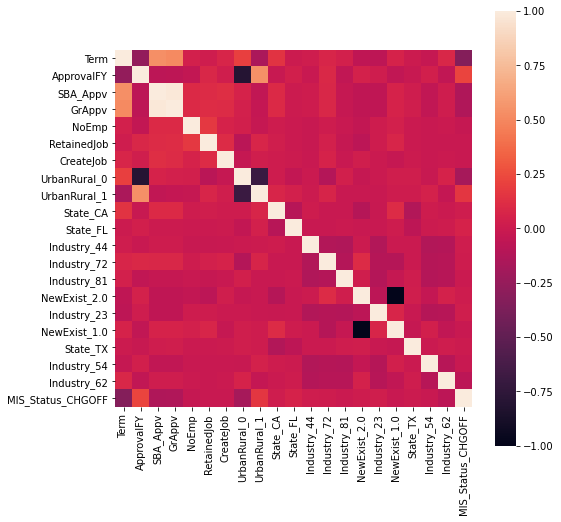

In [38]:
## Plot a heatmap of top twenty features, together with loan status. There are only a few very strong correlations here.
plt.figure(figsize = (8, 8))
ax = sns.heatmap(top_cols.corr(), xticklabels=True, yticklabels=True, square = True)

In [42]:
by_year = df_features.groupby('ApprovalFY')['MIS_Status_CHGOFF'].mean()

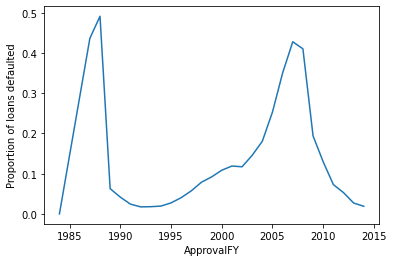

In [43]:
## Plot default rates by year. We see that there is a large spike for loans approved in mid-80's, 
## and another large one for laons approved in the late 2000's.
ax = by_year.plot(ylabel = 'Proportion of loans defaulted')

In [44]:
year_2007 = df_features.loc[df_features['ApprovalFY'] == 2007]

In [46]:
year_2007.head(10)

,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,GrAppv,SBA_Appv,State_AK,State_AL,State_AR,...,Industry_53,Industry_54,Industry_55,Industry_56,Industry_61,Industry_62,Industry_71,Industry_72,Industry_81,Industry_92
143680,2007,60,6,0,6,79500.0,67575.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143681,2007,60,1,0,1,35000.0,17500.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143684,2007,78,1,0,1,20000.0,10000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143685,2007,58,20,0,20,100000.0,50000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143690,2007,13,3,0,3,50000.0,25000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143693,2007,84,5,0,5,150000.0,75000.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
143694,2007,118,1,0,0,20000.0,10000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143697,2007,60,10,2,10,40000.0,20000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143699,2007,32,2,2,2,50000.0,25000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143703,2007,60,3,0,3,50000.0,25000.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
